# Project B: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

# Task 1

In [2]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten, Dropout
# from keras.losses import CategoricalCrossentropy
# from keras import backend as K

tf.enable_v2_behavior()

builder = tfds.builder('mnist')
BATCH_SIZE = 256
NUM_EPOCHS = 12
NUM_CLASSES = 10  # 10 total classes.

# Data loading

In [ ]:
# Load train and test splits.
def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  subclass_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  return image, subclass_labels


mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
i = 0
for images, labels in mnist_train:
  i += 1
print(i)
# mnist_train

234


# Model creation

In [ ]:
#@test {"output": "ignore"}

# Build CNN teacher.
cnn_model = tf.keras.Sequential()

# your code start from here for stpe 2
cnn_model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation='relu', input_shape=(28, 28, 1)))
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
cnn_model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(10))

# Build fully connected student.
fc_model = tf.keras.Sequential()

# your code start from here for step 2
fc_model.add(Flatten())
fc_model.add(Dense(784, activation='relu'))
fc_model.add(Dense(784, activation='relu'))
fc_model.add(Dense(10))


# Teacher loss function

In [ ]:
@tf.function
def compute_teacher_loss(images, labels):
  """Compute subclass knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  subclass_logits = cnn_model(images, training=True)

  # Compute cross-entropy loss for subclasses.

  # your code start from here for step 3

  # Referenced https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class
  # bce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
  # cross_entropy_loss_value = bce(labels, subclass_logits).numpy()

  cross_entropy_loss_value = tf.nn.softmax_cross_entropy_with_logits(labels, subclass_logits)

  return cross_entropy_loss_value

# Student loss function

In [ ]:
#@test {"output": "ignore"}

# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 4. #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
 # your code start from here for step 3
  soft_targets = tf.nn.softmax(teacher_logits / temperature)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_subclass_logits = fc_model(images, training=True)

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.

  # your code start from here for step 3

  teacher_subclass_logits = cnn_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits, DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3

  cross_entropy_loss_value = ALPHA * tf.nn.softmax_cross_entropy_with_logits(labels, student_subclass_logits) + (1 - ALPHA) * distillation_loss_value
  
  return cross_entropy_loss_value

# Train and evaluation

In [ ]:
@tf.function
def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  class_logits = model(images, training=False)
  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)


def train_and_evaluate(model, compute_loss_fn):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """

  # your code start from here for step 4
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
        # your code start from here for step 4
        # subclass_logits = model(images, training=True)
        loss_value = compute_loss_fn(images, labels)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      num_correct += compute_num_correct(model, images, labels)[0].numpy()
    print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))


# Training models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir(r'/content/drive/My Drive/Colab Notebooks')

Mounted at /content/drive


In [ ]:
# your code start from here for step 5 

# Teacher model:
train_and_evaluate(cnn_model, compute_teacher_loss)

Epoch 1: Class_accuracy: 98.02%
Epoch 2: Class_accuracy: 98.54%
Epoch 3: Class_accuracy: 98.88%
Epoch 4: Class_accuracy: 98.83%
Epoch 5: Class_accuracy: 99.12%
Epoch 6: Class_accuracy: 99.03%
Epoch 7: Class_accuracy: 99.06%
Epoch 8: Class_accuracy: 99.16%
Epoch 9: Class_accuracy: 99.11%
Epoch 10: Class_accuracy: 99.13%
Epoch 11: Class_accuracy: 99.20%
Epoch 12: Class_accuracy: 99.31%


In [ ]:
from keras.models import load_model

# cnn_model.save("cnn_model.h5")
cnn_model=load_model('cnn_model.h5')

In [ ]:
# Student model
train_and_evaluate(fc_model, compute_student_loss)

Epoch 1: Class_accuracy: 96.85%
Epoch 2: Class_accuracy: 97.84%
Epoch 3: Class_accuracy: 98.26%
Epoch 4: Class_accuracy: 98.42%
Epoch 5: Class_accuracy: 98.48%
Epoch 6: Class_accuracy: 98.61%
Epoch 7: Class_accuracy: 98.65%
Epoch 8: Class_accuracy: 98.79%
Epoch 9: Class_accuracy: 98.76%
Epoch 10: Class_accuracy: 98.83%
Epoch 11: Class_accuracy: 98.80%
Epoch 12: Class_accuracy: 98.92%


In [ ]:
from keras.models import load_model

# fc_model.save("origin_fc_model.h5")
fc_model=load_model('origin_fc_model.h5')

In [ ]:
# Tune task balance parameter
DISTILLATION_TEMPERATURE = 4.
tune_balance = [0, 0.2, 0.4, 0.6, 0.8, 1]
for i in tune_balance:
  ALPHA = i
  print("Task Balance: " + str(ALPHA))

  fc_model = tf.keras.Sequential()
  fc_model.add(Flatten())
  fc_model.add(Dense(784, activation='relu'))
  fc_model.add(Dense(784, activation='relu'))
  fc_model.add(Dense(10))
  
  train_and_evaluate(fc_model, compute_student_loss)

Task Balance: 0
Epoch 1: Class_accuracy: 96.79%
Epoch 2: Class_accuracy: 97.81%
Epoch 3: Class_accuracy: 98.21%
Epoch 4: Class_accuracy: 98.44%
Epoch 5: Class_accuracy: 98.59%
Epoch 6: Class_accuracy: 98.70%
Epoch 7: Class_accuracy: 98.79%
Epoch 8: Class_accuracy: 98.73%
Epoch 9: Class_accuracy: 98.86%
Epoch 10: Class_accuracy: 98.83%
Epoch 11: Class_accuracy: 98.90%
Epoch 12: Class_accuracy: 98.89%
Task Balance: 0.2
Epoch 1: Class_accuracy: 96.97%
Epoch 2: Class_accuracy: 97.89%
Epoch 3: Class_accuracy: 98.16%
Epoch 4: Class_accuracy: 98.36%
Epoch 5: Class_accuracy: 98.48%
Epoch 6: Class_accuracy: 98.70%
Epoch 7: Class_accuracy: 98.73%
Epoch 8: Class_accuracy: 98.72%
Epoch 9: Class_accuracy: 98.73%
Epoch 10: Class_accuracy: 98.75%
Epoch 11: Class_accuracy: 98.87%
Epoch 12: Class_accuracy: 98.90%
Task Balance: 0.4
Epoch 1: Class_accuracy: 96.84%
Epoch 2: Class_accuracy: 97.79%
Epoch 3: Class_accuracy: 98.25%
Epoch 4: Class_accuracy: 98.39%
Epoch 5: Class_accuracy: 98.61%
Epoch 6: Class

# Test accuracy vs. tempreture curve

In [ ]:
# your code start from here for step 6
ALPHA = 0.5
tune_temp = [1., 2., 4., 16., 32., 64.]
for i in tune_temp:
  DISTILLATION_TEMPERATURE = i
  print("Temperature: " + str(DISTILLATION_TEMPERATURE))

  fc_model = tf.keras.Sequential()
  fc_model.add(Flatten())
  fc_model.add(Dense(784, activation='relu'))
  fc_model.add(Dense(784, activation='relu'))
  fc_model.add(Dense(10))

  train_and_evaluate(fc_model, compute_student_loss)

Temperature: 1.0
Epoch 1: Class_accuracy: 96.69%
Epoch 2: Class_accuracy: 97.47%
Epoch 3: Class_accuracy: 98.16%
Epoch 4: Class_accuracy: 97.74%
Epoch 5: Class_accuracy: 98.05%
Epoch 6: Class_accuracy: 98.07%
Epoch 7: Class_accuracy: 98.01%
Epoch 8: Class_accuracy: 98.28%
Epoch 9: Class_accuracy: 98.19%
Epoch 10: Class_accuracy: 98.12%
Epoch 11: Class_accuracy: 98.26%
Epoch 12: Class_accuracy: 98.50%
Temperature: 2.0
Epoch 1: Class_accuracy: 96.70%
Epoch 2: Class_accuracy: 97.56%
Epoch 3: Class_accuracy: 97.94%
Epoch 4: Class_accuracy: 98.23%
Epoch 5: Class_accuracy: 98.32%
Epoch 6: Class_accuracy: 98.43%
Epoch 7: Class_accuracy: 98.51%
Epoch 8: Class_accuracy: 98.64%
Epoch 9: Class_accuracy: 98.60%
Epoch 10: Class_accuracy: 98.76%
Epoch 11: Class_accuracy: 98.66%
Epoch 12: Class_accuracy: 98.61%
Temperature: 4.0
Epoch 1: Class_accuracy: 96.75%
Epoch 2: Class_accuracy: 97.95%
Epoch 3: Class_accuracy: 98.37%
Epoch 4: Class_accuracy: 98.46%
Epoch 5: Class_accuracy: 98.62%
Epoch 6: Class_

# Train student from scratch

In [ ]:
# Build fully connected student.
fc_model_no_distillation = tf.keras.Sequential()

# your code start from here for step 7
fc_model_no_distillation.add(Flatten())
fc_model_no_distillation.add(Dense(784, activation='relu'))
fc_model_no_distillation.add(Dense(784, activation='relu'))
fc_model_no_distillation.add(Dense(10))

#@test {"output": "ignore"}

def compute_plain_cross_entropy_loss(images, labels):
  """Compute plain loss for given images and labels.

  For fair comparison and convenience, this function also performs a
  LogSumExp over subclasses, but does not perform subclass distillation.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  # your code start from here for step 7

  student_subclass_logits = fc_model_no_distillation(images, training=True)
  cross_entropy_loss = tf.nn.softmax_cross_entropy_with_logits(labels, student_subclass_logits)
  
  return cross_entropy_loss

# Student from scratch
train_and_evaluate(fc_model_no_distillation, compute_plain_cross_entropy_loss)

Epoch 1: Class_accuracy: 96.79%
Epoch 2: Class_accuracy: 97.71%
Epoch 3: Class_accuracy: 97.82%
Epoch 4: Class_accuracy: 98.08%
Epoch 5: Class_accuracy: 97.91%
Epoch 6: Class_accuracy: 98.14%
Epoch 7: Class_accuracy: 97.88%
Epoch 8: Class_accuracy: 97.81%
Epoch 9: Class_accuracy: 97.96%
Epoch 10: Class_accuracy: 97.94%
Epoch 11: Class_accuracy: 98.13%
Epoch 12: Class_accuracy: 98.13%


In [ ]:
from keras.models import load_model

# fc_model_no_distillation.save("nd_fc_model.h5")
fc_model_no_distillation=load_model('nd_fc_model.h5')

# Comparing the teacher and student model (number of of parameters and FLOPs) 

In [ ]:
# your code start from here for step 8
!pip install keras-flops
from keras_flops import get_flops

print("--------------------------------------------------------------------------------------------")

cnn_model.summary()
fc_model.summary()

teacher_flops = get_flops(cnn_model, batch_size=1)
student_flops = get_flops(fc_model, batch_size=1)
print("FLOPs of Teacher Model: " + str(teacher_flops))
print("FLOPs of Student Model: " + str(student_flops))

--------------------------------------------------------------------------------------------
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 23, 23, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 7744)              0         
                           

FLOPs of Teacher Model: 22042058
FLOPs of Student Model: 2475882


# XAI method to explain models

In [ ]:
# your code start from here for step 9
# Refered to the notebooks of Project 1
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir(r'/content/drive/My Drive/Colab Notebooks')

from xai_utils import *

# Need to change the function a little bit...
def RISE(img, model, class_index, N_MASKS=8000, H=28, W=28, C=1):
    '''
	img: a 3-D input image
	model: a trained model
	class_index; The class of interest
	N_MASKS: The number of random masks to be generated
	H,W,C: The desired dimensions of the random masks
	'''
    X = np.zeros(shape=(N_MASKS, H, W, C), dtype=np.float32)
    masks = np.zeros((N_MASKS,H,W), dtype=np.float32)
    #for i in tqdm(range(N_MASKS)):
    for i in range(N_MASKS):
        m =create_random_mask(H=H, W=W)
        masks[i] = m
        x = img.copy()
        x[:, :, 0] *= m
        X[i] = x
    preds_masked = model.predict(X, verbose=0)
    sum_mask = np.zeros(masks[0].shape, dtype=np.float32)

    # np.einsum???
    for i, mask in enumerate(masks):
        m = mask * preds_masked[i, class_index]
        sum_mask += m

    sum_mask -= np.min(sum_mask)
    sum_mask /= np.max(sum_mask)
    return sum_mask

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
image_sample = 0
label_sample = 0
for images, labels in mnist_test:
  image_sample = images[4]
  label_sample = labels[4]
  break

# RISE
# teacher model
explanation_map_teacher = RISE(image_sample.numpy(), cnn_model, class_index=np.argmax(label_sample) ,N_MASKS=1000)
explanation_map_teacher -= explanation_map_teacher.min()
explanation_map_teacher /= explanation_map_teacher.max()+10e-30

# student model with distillation
explanation_map_student = RISE(image_sample.numpy(), fc_model, class_index=np.argmax(label_sample) ,N_MASKS=1000)
explanation_map_student -= explanation_map_student.min()
explanation_map_student /= explanation_map_student.max()+10e-30

# student model without distillation
explanation_map_student_nd = RISE(image_sample.numpy(), fc_model_no_distillation, class_index=np.argmax(label_sample) ,N_MASKS=1000)
explanation_map_student_nd -= explanation_map_student_nd.min()
explanation_map_student_nd /= explanation_map_student_nd.max()+10e-30


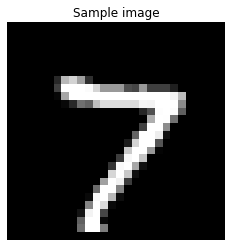

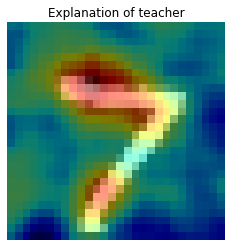

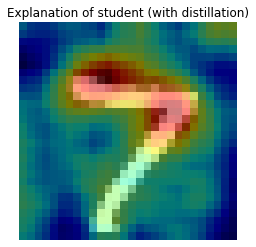

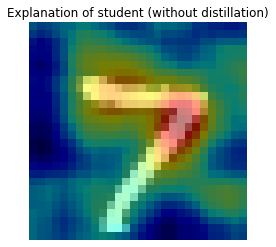

In [ ]:
import matplotlib.pyplot as plt

# plt.subplot(1,4,1)
plt.imshow(np.squeeze(image_sample), cmap="gray")
plt.axis('off')
plt.title('Sample image')
plt.show()

# plt.subplot(1,4,2)
plt.imshow(np.squeeze(image_sample), cmap="gray")
plt.imshow(explanation_map_teacher, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation of teacher')
plt.show()

# plt.subplot(1,4,3)
plt.imshow(np.squeeze(image_sample), cmap="gray")
plt.imshow(explanation_map_student, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation of student (with distillation)')
plt.show()

# plt.subplot(1,4,4)
plt.imshow(np.squeeze(image_sample), cmap="gray")
plt.imshow(explanation_map_student_nd, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation of student (without distillation)')
plt.show()

# Implementing the state-of-the-art KD algorithm

In [ ]:
# your code start from here for step 13

In [ ]:
# Referenced https://github.com/google-research/google-research/tree/01d59138d2a41465b25cdbb569524ad6ba1faaf1/subclass_distillation

# Cited as:
# @article{muller2020subclass,
# title={Subclass distillation},
# author={M{\"u}ller, Rafael and Kornblith, Simon and Hinton, Geoffrey},
# journal={arXiv preprint arXiv:2002.03936},
# year={2020}
# }

In [27]:
NUM_CLASSES = 2
NUM_SUBCLASSES = 10
ALPHA = 0.5
DISTILLATION_TEMPERATURE = 4.
BETA = 1.0
AUXILIARY_TEMPERATURE = 1.0

In [28]:
# Load dataset
def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  subclass_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  labels = tf.reduce_sum(tf.reshape(subclass_labels, (NUM_CLASSES, NUM_SUBCLASSES // NUM_CLASSES)), -1)
  return image, labels

mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)

In [29]:
# Model Creation

# teacher
cnn_model = tf.keras.Sequential()

cnn_model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation='relu', input_shape=(28, 28, 1)))
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
cnn_model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(10))

# student
fc_model = tf.keras.Sequential()

fc_model.add(Flatten())
fc_model.add(Dense(784, activation='relu'))
fc_model.add(Dense(784, activation='relu'))
fc_model.add(Dense(10))

In [30]:
# teacher functions
def auxiliary_loss(subclass_logits: tf.Tensor, temperature: Union[float, tf.Tensor]):

  # convert to tensor
  temperature = tf.convert_to_tensor(temperature, dtype=subclass_logits.dtype)

  # needed for normalization
  mean, vari = tf.nn.moments(subclass_logits, -1, keepdims=True)
  num_subclasses = tf.convert_to_tensor(NUM_SUBCLASSES / NUM_CLASSES, dtype=subclass_logits.dtype)

  # Use the value of the official implementation
  e = tf.convert_to_tensor(1e-9, dtype=subclass_logits.dtype)

  # normalized vi hat
  vi = tf.nn.batch_normalization(subclass_logits, mean=mean, variance=vari, offset=None, scale=1./ tf.sqrt(temperature * num_subclasses), variance_epsilon=e)
  n = tf.cast(BATCH_SIZE, subclass_logits.dtype)

  products = tf.linalg.matmul(vi, vi, transpose_b=True)
  return (tf.math.reduce_mean(tf.math.reduce_logsumexp(products, -1)) - 1/temperature -tf.math.log(n))

def compute_teacher_loss(images, labels):

  subclass_logits = cnn_model(images, training=True)

  # cross entropy 
  subclass_logits = tf.reshape(subclass_logits, (-1, NUM_CLASSES, NUM_SUBCLASSES // NUM_CLASSES))
  class_logits = tf.math.reduce_logsumexp(subclass_logits, -1)
  cross_entropy_loss_value = tf.nn.softmax_cross_entropy_with_logits(labels, class_logits)

  # auxiliary loss
  auxiliary_loss_value = auxiliary_loss(subclass_logits, AUXILIARY_TEMPERATURE)

  # total loss value
  loss_value = cross_entropy_loss_value + BETA * auxiliary_loss_value

  return loss_value

In [31]:
# student
def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor, temperature: Union[float, tf.Tensor]):

  soft_targets = tf.nn.softmax(teacher_logits / temperature)
  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2


def compute_student_loss(images, labels):

  student_subclass_logits = fc_model(images, training=True)

  teacher_subclass_logits = cnn_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits, DISTILLATION_TEMPERATURE)

  subclass_logits = tf.reshape(student_subclass_logits, (-1, NUM_CLASSES, NUM_SUBCLASSES // NUM_CLASSES))
  class_logits = tf.math.reduce_logsumexp(subclass_logits, -1)

  cross_entropy_loss_value = ALPHA * tf.nn.softmax_cross_entropy_with_logits(labels, class_logits) + (1 - ALPHA) * distillation_loss_value
  return cross_entropy_loss_value

In [32]:
# Train and evaluation
def compute_num_correct(model, images, labels):

  subclass_logits = model(images, training=False)
  subclass_logits = tf.reshape(subclass_logits, (-1, NUM_CLASSES, NUM_SUBCLASSES // NUM_CLASSES))
  class_logits = tf.math.reduce_logsumexp(subclass_logits, -1)

  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)

def train_and_evaluate(model, compute_loss_fn):

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
        loss_value = compute_loss_fn(images, labels)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      num_correct += compute_num_correct(model, images, labels)[0].numpy()
    print("Class_accuracy: " + '{:.2f}%'.format(num_correct / num_total * 100))

In [ ]:
# train teacher
train_and_evaluate(cnn_model, compute_teacher_loss)


Epoch 1: Class_accuracy: 97.88%
Epoch 2: Class_accuracy: 98.78%
Epoch 3: Class_accuracy: 98.65%
Epoch 4: Class_accuracy: 99.09%
Epoch 5: Class_accuracy: 99.10%
Epoch 6: Class_accuracy: 99.15%
Epoch 7: Class_accuracy: 99.24%
Epoch 8: Class_accuracy: 99.35%
Epoch 9: Class_accuracy: 99.30%
Epoch 10: Class_accuracy: 99.35%
Epoch 11: Class_accuracy: 99.39%
Epoch 12: Class_accuracy: 99.40%


In [18]:
#@title Train teacher，with 12 subclasses. This record is just for reference
train_and_evaluate(cnn_model, compute_teacher_loss)

Epoch 1: Class_accuracy: 98.11%
Epoch 2: Class_accuracy: 98.58%
Epoch 3: Class_accuracy: 98.95%
Epoch 4: Class_accuracy: 98.91%
Epoch 5: Class_accuracy: 98.97%
Epoch 6: Class_accuracy: 99.03%
Epoch 7: Class_accuracy: 99.21%
Epoch 8: Class_accuracy: 99.20%
Epoch 9: Class_accuracy: 99.20%
Epoch 10: Class_accuracy: 99.27%
Epoch 11: Class_accuracy: 99.39%
Epoch 12: Class_accuracy: 99.34%


In [ ]:
# train student
train_and_evaluate(fc_model, compute_student_loss)


Epoch 1: Class_accuracy: 97.69%
Epoch 2: Class_accuracy: 98.40%
Epoch 3: Class_accuracy: 98.55%
Epoch 4: Class_accuracy: 98.57%
Epoch 5: Class_accuracy: 98.67%
Epoch 6: Class_accuracy: 98.75%
Epoch 7: Class_accuracy: 98.76%
Epoch 8: Class_accuracy: 98.79%
Epoch 9: Class_accuracy: 98.82%
Epoch 10: Class_accuracy: 98.78%
Epoch 11: Class_accuracy: 98.76%
Epoch 12: Class_accuracy: 98.92%


In [ ]:
# student ftom scratch

fc_model_no_distillation = tf.keras.Sequential()
fc_model_no_distillation.add(tf.keras.layers.Flatten())
fc_model_no_distillation.add(tf.keras.layers.Dense(784, activation='relu'))
fc_model_no_distillation.add(tf.keras.layers.Dense(784, activation='relu'))
fc_model_no_distillation.add(tf.keras.layers.Dense(10))

def compute_plain_cross_entropy_loss(images, labels):

  student_class_logits = fc_model_no_distillation(images, training=True)
  cross_entropy_loss = tf.nn.softmax_cross_entropy_with_logits(labels, student_class_logits)
  return cross_entropy_loss

train_and_evaluate(fc_model_no_distillation, compute_plain_cross_entropy_loss)

Epoch 1: 97.98%
Epoch 2: 98.19%
Epoch 3: 98.18%
Epoch 4: 97.89%
Epoch 5: 98.41%
Epoch 6: 98.26%
Epoch 7: 98.59%
Epoch 8: 98.51%
Epoch 9: 98.41%
Epoch 10: 98.41%
Epoch 11: 98.52%
Epoch 12: 98.39%


## Draw graphs base on generated datum

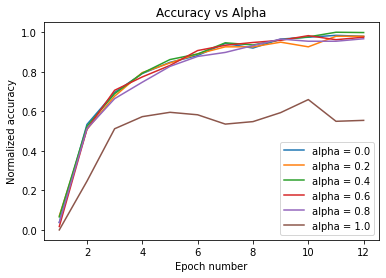

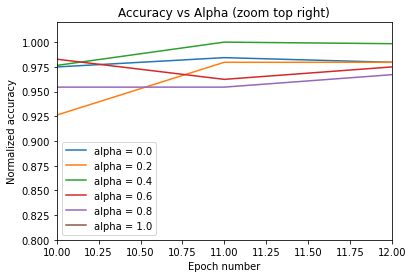

In [23]:

# tune alpha
balance_1_00 = np.array([96.74, 97.97, 98.26, 98.53, 98.59, 98.65, 98.76, 98.73, 98.80, 98.84, 98.82, 98.83])
balance_1_02 = np.array([96.89, 97.69, 98.19, 98.42, 98.54, 98.62, 98.62, 98.72, 98.68, 98.68, 98.80, 98.77])
balance_1_04 = np.array([96.94, 97.89, 98.29, 98.52, 98.67, 98.66, 98.93, 98.72, 98.80, 98.80, 98.87, 98.85])
balance_1_06 = np.array([96.70, 97.84, 98.27, 98.32, 98.49, 98.76, 98.70, 98.73, 98.70, 98.84, 98.78, 98.78])
balance_1_08 = np.array([96.87, 97.84, 98.10, 98.39, 98.42, 98.57, 98.63, 98.70, 98.78, 98.77, 98.83, 98.80])
balance_1_10 = np.array([96.52, 97.05, 97.84, 97.83, 97.81, 98.05, 97.97, 97.54, 98.09, 98.03, 98.08, 98.00])

balance_2_00 = np.array([96.93, 97.84, 98.18, 98.29, 98.44, 98.49, 98.68, 98.62, 98.71, 98.76, 98.77, 98.74])
balance_2_02 = np.array([96.81, 97.88, 98.18, 98.51, 98.58, 98.57, 98.77, 98.68, 98.86, 98.69, 98.79, 98.79])
balance_2_04 = np.array([96.86, 97.88, 98.07, 98.36, 98.43, 98.54, 98.58, 98.75, 98.77, 98.79, 98.82, 98.82])
balance_2_06 = np.array([96.71, 97.86, 98.23, 98.39, 98.51, 98.62, 98.65, 98.72, 98.81, 98.80, 98.79, 98.80])
balance_2_08 = np.array([96.57, 97.79, 98.17, 98.28, 98.59, 98.57, 98.58, 98.69, 98.71, 98.74, 98.75, 98.81])
balance_2_10 = np.array([97.18, 97.09, 97.73, 97.97, 98.09, 97.88, 97.93, 98.24, 98.06, 98.16, 97.58, 97.98])

balance_3_00 = np.array([96.79, 97.81, 98.21, 98.44, 98.59, 98.70, 98.79, 98.73, 98.86, 98.83, 98.90, 98.89])
balance_3_02 = np.array([96.97, 97.89, 98.16, 98.36, 98.48, 98.70, 98.73, 98.72, 98.73, 98.75, 98.87, 98.90])
balance_3_04 = np.array([96.84, 97.79, 98.25, 98.39, 98.61, 98.69, 98.74, 98.71, 98.78, 98.85, 98.90, 98.91])
balance_3_06 = np.array([96.92, 97.77, 98.22, 98.44, 98.52, 98.62, 98.82, 98.81, 98.82, 98.84, 98.78, 98.85])
balance_3_08 = np.array([97.02, 97.85, 98.18, 98.31, 98.48, 98.67, 98.73, 98.77, 98.88, 98.79, 98.72, 98.77])
balance_3_10 = np.array([96.52, 97.65, 97.91, 98.07, 98.11, 98.00, 97.73, 97.93, 97.85, 98.23, 98.06, 97.77])

balance00 = (np.mean(np.array([balance_1_00, balance_2_00, balance_3_00]), axis=0))
balance02 = (np.mean(np.array([balance_1_02, balance_2_02, balance_3_02]), axis=0))
balance04 = (np.mean(np.array([balance_1_04, balance_2_04, balance_3_04]), axis=0))
balance06 = (np.mean(np.array([balance_1_06, balance_2_06, balance_3_06]), axis=0))
balance08 = (np.mean(np.array([balance_1_08, balance_2_08, balance_3_08]), axis=0))
balance10 = (np.mean(np.array([balance_1_10, balance_2_10, balance_3_10]), axis=0))

max_value = np.amax([balance00, balance02, balance04, balance06, balance08, balance10])
min_value = np.amin([balance00, balance02, balance04, balance06, balance08, balance10])

balance00 = (np.mean(np.array([balance_1_00, balance_2_00, balance_3_00]), axis=0) -min_value) / (max_value - min_value)
balance02 = (np.mean(np.array([balance_1_02, balance_2_02, balance_3_02]), axis=0) -min_value) / (max_value - min_value)
balance04 = (np.mean(np.array([balance_1_04, balance_2_04, balance_3_04]), axis=0) -min_value) / (max_value - min_value)
balance06 = (np.mean(np.array([balance_1_06, balance_2_06, balance_3_06]), axis=0) -min_value) / (max_value - min_value)
balance08 = (np.mean(np.array([balance_1_08, balance_2_08, balance_3_08]), axis=0) -min_value) / (max_value - min_value)
balance10 = (np.mean(np.array([balance_1_10, balance_2_10, balance_3_10]), axis=0) -min_value) / (max_value - min_value)

x = list(range(1, 13))

plt.figure(1)
plt.plot(x, balance00, label = "alpha = 0.0")
plt.plot(x, balance02, label = "alpha = 0.2")
plt.plot(x, balance04, label = "alpha = 0.4")
plt.plot(x, balance06, label = "alpha = 0.6")
plt.plot(x, balance08, label = "alpha = 0.8")
plt.plot(x, balance10, label = "alpha = 1.0")

plt.title('Accuracy vs Alpha')
plt.ylabel('Normalized accuracy')
plt.xlabel('Epoch number')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(10, 12)
plt.ylim(0.8, 1.02)
plt.plot(x, balance00, label = "alpha = 0.0")
plt.plot(x, balance02, label = "alpha = 0.2")
plt.plot(x, balance04, label = "alpha = 0.4")
plt.plot(x, balance06, label = "alpha = 0.6")
plt.plot(x, balance08, label = "alpha = 0.8")
plt.plot(x, balance10, label = "alpha = 1.0")

plt.title('Accuracy vs Alpha (zoom top right)')
plt.ylabel('Normalized accuracy')
plt.xlabel('Epoch number')
plt.legend(loc='best')
plt.show()

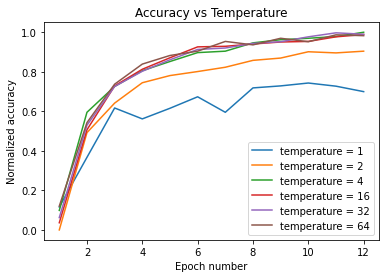

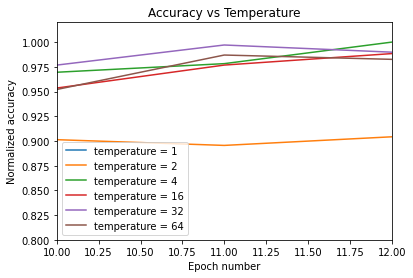

In [25]:
# tune temperature
temp_1_01 = [96.72, 97.46, 97.91, 97.71, 98.02, 98.21, 98.02, 98.06, 98.38, 98.34, 98.27, 97.57]
temp_1_02 = [96.71, 97.84, 98.10, 98.33, 98.39, 98.36, 98.37, 98.45, 98.57, 98.58, 98.57, 98.59]
temp_1_04 = [96.80, 98.03, 98.09, 98.39, 98.49, 98.53, 98.57, 98.73, 98.74, 98.73, 98.78, 98.83]
temp_1_16 = [96.60, 97.71, 98.17, 98.46, 98.61, 98.68, 98.73, 98.78, 98.79, 98.76, 98.78, 98.87]
temp_1_32 = [96.59, 97.73, 98.25, 98.44, 98.61, 98.69, 98.78, 98.79, 98.84, 98.86, 98.96, 98.94]
temp_1_64 = [96.75, 97.78, 98.31, 98.51, 98.56, 98.66, 98.77, 98.78, 98.86, 98.84, 98.88, 98.84]

temp_2_01 = [97.11, 97.32, 97.90, 98.14, 97.89, 98.08, 97.79, 98.33, 98.17, 98.38, 98.20, 98.47]
temp_2_02 = [96.31, 97.71, 98.10, 98.29, 98.39, 98.45, 98.51, 98.54, 98.54, 98.59, 98.66, 98.75]
temp_2_04 = [96.85, 97.84, 98.26, 98.42, 98.48, 98.61, 98.65, 98.79, 98.76, 98.83, 98.80, 98.92]
temp_2_16 = [96.72, 97.69, 98.24, 98.44, 98.62, 98.67, 98.71, 98.70, 98.75, 98.81, 98.85, 98.85]
temp_2_32 = [96.84, 97.81, 98.32, 98.40, 98.56, 98.65, 98.68, 98.78, 98.75, 98.82, 98.84, 98.76]
temp_2_64 = [96.88, 97.88, 98.26, 98.48, 98.66, 98.66, 98.79, 98.72, 98.81, 98.73, 98.84, 98.88]

temp_3_01 = [96.69, 97.47, 98.16, 97.74, 98.05, 98.07, 98.01, 98.28, 98.19, 98.12, 98.26, 98.50]
temp_3_02 = [96.70, 97.56, 97.94, 98.23, 98.32, 98.43, 98.51, 98.64, 98.60, 98.76, 98.66, 98.61]
temp_3_04 = [96.75, 97.95, 98.37, 98.46, 98.62, 98.76, 98.73, 98.72, 98.85, 98.84, 98.88, 98.86]
temp_3_16 = [96.65, 97.81, 98.33, 98.42, 98.49, 98.75, 98.68, 98.72, 98.73, 98.72, 98.82, 98.81]
temp_3_32 = [96.72, 97.83, 98.15, 98.41, 98.48, 98.67, 98.60, 98.65, 98.69, 98.77, 98.79, 98.84]
temp_3_64 = [96.92, 97.80, 98.23, 98.51, 98.58, 98.63, 98.73, 98.67, 98.73, 98.71, 98.80, 98.77]

temp01 = (np.mean(np.array([temp_1_01, temp_2_01, temp_3_01]), axis=0))
temp02 = (np.mean(np.array([temp_1_02, temp_2_02, temp_3_02]), axis=0))
temp04 = (np.mean(np.array([temp_1_04, temp_2_04, temp_3_04]), axis=0))
temp16 = (np.mean(np.array([temp_1_16, temp_2_16, temp_3_16]), axis=0))
temp32 = (np.mean(np.array([temp_1_32, temp_2_32, temp_3_32]), axis=0))
temp64 = (np.mean(np.array([temp_1_64, temp_2_64, temp_3_64]), axis=0))

max_value = np.amax([temp01, temp02, temp04, temp16, temp32, temp64])
min_value = np.amin([temp01, temp02, temp04, temp16, temp32, temp64])

temp01 = (np.mean(np.array([temp_1_01, temp_2_01, temp_3_01]), axis=0) -min_value) / (max_value - min_value)
temp02 = (np.mean(np.array([temp_1_02, temp_2_02, temp_3_02]), axis=0) -min_value) / (max_value - min_value)
temp04 = (np.mean(np.array([temp_1_04, temp_2_04, temp_3_04]), axis=0) -min_value) / (max_value - min_value)
temp16 = (np.mean(np.array([temp_1_16, temp_2_16, temp_3_16]), axis=0) -min_value) / (max_value - min_value)
temp32 = (np.mean(np.array([temp_1_32, temp_2_32, temp_3_32]), axis=0) -min_value) / (max_value - min_value)
temp64 = (np.mean(np.array([temp_1_64, temp_2_64, temp_3_64]), axis=0) -min_value) / (max_value - min_value)

x = list(range(1, 13))

plt.figure(1)
plt.plot(x, temp01, label = "temperature = 1")
plt.plot(x, temp02, label = "temperature = 2")
plt.plot(x, temp04, label = "temperature = 4")
plt.plot(x, temp16, label = "temperature = 16")
plt.plot(x, temp32, label = "temperature = 32")
plt.plot(x, temp64, label = "temperature = 64")

plt.title('Accuracy vs Temperature')
plt.ylabel('Normalized accuracy')
plt.xlabel('Epoch number')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(10, 12)
plt.ylim(0.8, 1.02)
plt.plot(x, temp01, label = "temperature = 1")
plt.plot(x, temp02, label = "temperature = 2")
plt.plot(x, temp04, label = "temperature = 4")
plt.plot(x, temp16, label = "temperature = 16")
plt.plot(x, temp32, label = "temperature = 32")
plt.plot(x, temp64, label = "temperature = 64")

plt.title('Accuracy vs Temperature')
plt.ylabel('Normalized accuracy')
plt.xlabel('Epoch number')
plt.legend(loc='best')
plt.show()


# Archived, just some drafts

In [ ]:
#@title Test training plain teacher model
# teacher
testmodel_t = tf.keras.Sequential()

testmodel_t.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation='relu', input_shape=(28, 28, 1)))
testmodel_t.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
testmodel_t.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
testmodel_t.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
testmodel_t.add(Flatten())
testmodel_t.add(Dropout(0.5))
testmodel_t.add(Dense(128, activation='relu'))
testmodel_t.add(Dropout(0.5))
testmodel_t.add(Dense(10, activation='softmax'))

testmodel_t.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

for i in range(12):
  testmodel_t.fit(mnist_train)

  num_correct = 0
  num_total = builder.info.splits['test'].num_examples
  for images, labels in mnist_test:
    num_correct += compute_num_correct(testmodel_t, images, labels)[0].numpy()
  print("Class_accuracy: " + '{:.2f}%'.format(
      num_correct / num_total * 100))

234/234 [==============================] - 137s 577ms/step - loss: 0.3030 - accuracy: 0.9060
Class_accuracy: 98.31%
234/234 [==============================] - 137s 577ms/step - loss: 0.0950 - accuracy: 0.9718
Class_accuracy: 98.70%
234/234 [==============================] - 137s 580ms/step - loss: 0.0723 - accuracy: 0.9780
Class_accuracy: 98.92%
234/234 [==============================] - 136s 575ms/step - loss: 0.0613 - accuracy: 0.9816
Class_accuracy: 98.92%
234/234 [==============================] - 136s 572ms/step - loss: 0.0552 - accuracy: 0.9832
Class_accuracy: 98.92%
234/234 [==============================] - 136s 575ms/step - loss: 0.0491 - accuracy: 0.9850
Class_accuracy: 99.00%
234/234 [==============================] - 135s 571ms/step - loss: 0.0460 - accuracy: 0.9851
Class_accuracy: 99.09%
234/234 [==============================] - 135s 571ms/step - loss: 0.0408 - accuracy: 0.9872
Class_accuracy: 99.02%
234/234 [==============================] - 136s 573ms/step - loss: 0.037

In [ ]:
#@title Test training plain student model

# student
testmodel = tf.keras.Sequential()

testmodel.add(Flatten())
testmodel.add(Dense(784, activation='relu'))
testmodel.add(Dense(784, activation='relu'))
testmodel.add(Dense(10, activation='softmax'))

testmodel.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

for i in range(12):
  testmodel.fit(mnist_train)

  num_correct = 0
  num_total = builder.info.splits['test'].num_examples
  for images, labels in mnist_test:
    num_correct += compute_num_correct(testmodel, images, labels)[0].numpy()
  print("Class_accuracy: " + '{:.2f}%'.format(
      num_correct / num_total * 100))

234/234 [==============================] - 11s 37ms/step - loss: 0.2352 - accuracy: 0.9314
Class_accuracy: 96.04%
234/234 [==============================] - 10s 36ms/step - loss: 0.0799 - accuracy: 0.9763
Class_accuracy: 97.40%
234/234 [==============================] - 10s 35ms/step - loss: 0.0497 - accuracy: 0.9844
Class_accuracy: 97.83%
234/234 [==============================] - 10s 37ms/step - loss: 0.0332 - accuracy: 0.9895
Class_accuracy: 97.91%
234/234 [==============================] - 10s 35ms/step - loss: 0.0229 - accuracy: 0.9927
Class_accuracy: 97.79%
234/234 [==============================] - 10s 35ms/step - loss: 0.0159 - accuracy: 0.9949
Class_accuracy: 97.98%
234/234 [==============================] - 10s 35ms/step - loss: 0.0181 - accuracy: 0.9939
Class_accuracy: 98.09%
234/234 [==============================] - 10s 35ms/step - loss: 0.0142 - accuracy: 0.9954
Class_accuracy: 98.13%
234/234 [==============================] - 10s 35ms/step - loss: 0.0128 - accuracy: 0.99